Generated partially with ChatGPT (chat.openai.com).


In [2]:

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import numpy as np
import random
from tqdm import tqdm
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal



# Define the DNN model
class DNN(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(DNN, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        out = self.fc1(x)
        out = self.relu(out)
        out = self.fc2(out)
        return out

# Define a custom dataset
class CustomDataset(Dataset):
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx], self.labels[idx]



In [3]:
class MoGData(object):
  def __init__(self):
    # Define the parameters for the two Gaussian distributions
    self.mu0 = [-1.5, -1.5]
    self.sigma0 = [[1, 0], [0, 1]]
    self.distrib0 = multivariate_normal(mean=self.mu0, cov=self.sigma0)
    self.mu1 = [1.5, 1.5]
    self.sigma1 = [[1, 0], [0, 1]]
    self.distrib1 = multivariate_normal(mean=self.mu1, cov=self.sigma1)

  def sample_data(self, num_samples = 10000):
    # Generate samples from the two Gaussian distributions
    samples0 = np.random.multivariate_normal(self.mu0, self.sigma0, num_samples)
    samples1 = np.random.multivariate_normal(self.mu1, self.sigma1, num_samples)

    # Combine the samples and create labels
    data = np.concatenate((samples0, samples1)).astype(np.float32)
    labels = np.concatenate((np.zeros(num_samples), np.ones(num_samples))).astype(int)

    # Shuffle the data and labels together
    combined = list(zip(data, labels))
    # random.shuffle(combined)
    data[:], labels[:] = zip(*combined)
    return data, labels

  def plot(self, num_samples):
    data, labels = self.sample_data(num_samples)
    samples0 = data[labels==0]
    samples1 = data[labels==1]
    plt.scatter(samples0[:, 0], samples0[:, 1], c='r', label='class 0', alpha=0.05)
    plt.scatter(samples1[:, 0], samples1[:, 1], c='b', label='class 1', alpha=0.05)
    plt.legend()
    plt.show()

  def compute_likelihood(self, data_points, which_class):
    if which_class == 0:
      return self.distrib0.pdf(data_points)
    elif which_class == 1:
      return self.distrib1.pdf(data_points)
    else:
      raise ValueError()

  def compute_likelihood_ratio(self, data_points):
    """p(y=0|x), assuming p(y=0)=p(y=1)=0.5"""
    l0 = self.compute_likelihood(data_points, which_class=0)
    l1 = self.compute_likelihood(data_points, which_class=1)
    return l0 / (l0+l1)




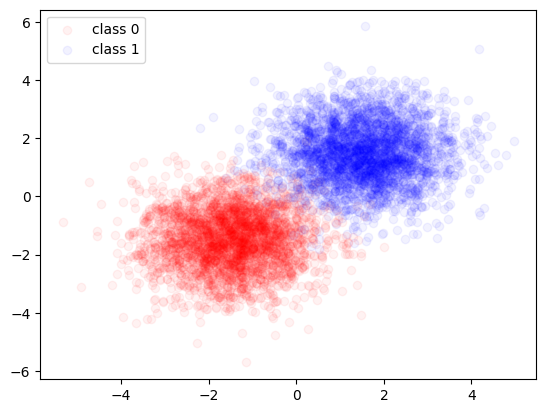

100%|██████████| 2000/2000 [00:03<00:00, 597.10it/s]


In [4]:
num_samples = 1000000
batch_size = 1000
learning_rate = 1

mog_data = MoGData()
mog_data.plot(num_samples=3000)

model = DNN(2, 10, 2)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=learning_rate)
train_loader = DataLoader(CustomDataset(*mog_data.sample_data(num_samples=num_samples)),
                          batch_size=batch_size,
                          shuffle=True)

pbar = tqdm(total=len(train_loader))
for i, (inputs, labels) in enumerate(train_loader):
  optimizer.zero_grad()
  outputs = model(inputs)
  loss = criterion(outputs, labels)
  loss.backward()
  optimizer.step()
  pbar.update(1)
pbar.close()

In [ ]:
model2 = DNN(2, 10, 2)
criterion2 = nn.CrossEntropyLoss()

In [5]:
def generate_mesh(min_x, max_x, min_y, max_y, num_x, num_y):
  # Define the range of x and y values
  x_range = np.linspace(-5, 5, num_x)
  y_range = np.linspace(-5, 5, num_y)

  # Generate the grid of points
  X, Y = np.meshgrid(x_range, y_range)

  mesh = np.stack((X.reshape(-1),Y.reshape(-1)), axis=1)
  return mesh

min_x = min_y = -500
max_x = max_y = 500
num_x = num_y = 101

mesh_np = generate_mesh(min_x=min_x, max_x=max_x, min_y=min_y, max_y=max_y, num_x=num_x, num_y=num_y).astype(np.float32)

inputs = torch.from_numpy(mesh_np)
outputs = model(inputs)
pred_probs = F.softmax(outputs)[:, 0].detach().numpy()
gt_probs = mog_data.compute_likelihood_ratio(mesh_np)


/tmp/ipykernel_2730779/1404021934.py:20: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pred_probs = F.softmax(outputs)[:, 0].detach().numpy()


In [6]:
# generate a test dataset from the distribution
test_data, test_labels = mog_data.sample_data(num_samples=10000)

# get the prediction 
test_outputs = model(torch.from_numpy(test_data))
test_pred_probs = torch.max(F.softmax(test_outputs), dim=1)[0]
test_pred_labels = torch.max(test_outputs, dim=1)[1]

(test_pred_labels == test_labels).sum()/len(test_labels)

/tmp/ipykernel_2730779/3026818656.py:6: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  test_pred_probs = torch.max(F.softmax(test_outputs), dim=1)[0]


tensor(0.9842)

In [8]:
def set_seed(seed):
  random.seed(seed)
  np.random.seed(seed)
  torch.manual_seed(seed)
  torch.cuda.manual_seed(seed)
  torch.cuda.manual_seed_all(seed)
  torch.backends.cudnn.deterministic = True
  torch.backends.cudnn.benchmark = False

# set_seed(18222)


# Select points with probabilities between 0.8 and 0.85, give back the indices
selected_indices = torch.where((test_pred_probs > 0.7) & (test_pred_probs < 0.85))
# selected_indices = torch.where(test_pred_probs > 0.0)

# randomly sample 1 number from the selected indices
poi_index = random.choice(selected_indices[0].numpy())
poi_data = test_data[poi_index]
poi_label = test_labels[poi_index]
poi_pred_prob = test_pred_probs[poi_index]
poi_pred_label = test_pred_labels[poi_index]

# compute the likelihood ratio for the poi_data
poi_gt_prob = mog_data.compute_likelihood_ratio(poi_data) if poi_pred_label == 0 else 1 - mog_data.compute_likelihood_ratio(poi_data)

print(f"The POI is {poi_data} with label {poi_label} and prediction probability {poi_pred_prob} and prediction label {poi_pred_label}")
print(f"The ground truth probability of the POI is {poi_gt_prob}")

# get the points with confidence around poi_pred_prob less than 0.01
confidence_gap = 0.03
confidence_high_threshold = poi_pred_prob + confidence_gap/2
confidence_low_threshold = poi_pred_prob - confidence_gap/2
# get the indices of the points with confidence around poi_pred_prob less than 0.01
confidence_indices = torch.where((test_pred_probs > confidence_low_threshold) & (test_pred_probs < confidence_high_threshold))
calibration_error_acc = (test_pred_labels[confidence_indices] == test_labels[confidence_indices]).sum()/len(confidence_indices[0])
print(f"The accuracy of the {len(confidence_indices[0])} points with confidence gap {confidence_gap} around point of interest {poi_pred_prob} is {calibration_error_acc}")
print(f"The gap between the accuracy and the ground truth probability of the POI is {abs(calibration_error_acc - poi_gt_prob)}")


eps = 0.61
poi_data_around = poi_data + np.random.uniform(-eps, eps, size=(1000,) + poi_data.shape)

# calculate the predicted label of these neighboring points
output_labels_around = model(torch.from_numpy(poi_data_around).float())
pred_labels_around = torch.max(output_labels_around, dim=1)[1]
pred_labels_conf = torch.max(F.softmax(output_labels_around, dim=1), dim=1)[0]


aggregation_result = pred_labels_around.sum()/len(pred_labels_around)
aggregation_result = max(aggregation_result.item(), 1 - aggregation_result.item())
print(f"The consistency eps: {eps:.2f}, pred_labels_around: {aggregation_result}")
print(f"The gap between the consistency (eps={eps:.2f}) and the ground truth probability of the POI is {abs(aggregation_result - poi_gt_prob)}")


The POI is [-0.01894808  0.42928478] with label 1 and prediction probability 0.7685840725898743 and prediction label 1
The ground truth probability of the POI is 0.7739953181018429
The accuracy of the 93 points with confidence gap 0.03 around point of interest 0.7685840725898743 is 0.7956989407539368
The gap between the accuracy and the ground truth probability of the POI is 0.021703600883483887
The consistency eps: 0.61, pred_labels_around: 0.7670000195503235
The gap between the consistency (eps=0.61) and the ground truth probability of the POI is 0.006995298551519369


In [9]:
for i in range(1000):
    # sample 1000 points around the poi_data, the distance is sampled from a uniform distribution between 0 and 0.1
    eps = i/1000
    poi_data_around = poi_data + np.random.uniform(-eps, eps, size=(1000,) + poi_data.shape)

    # calculate the predicted label of these neighboring points
    output_labels_around = model(torch.from_numpy(poi_data_around).float())
    pred_labels_around = torch.max(output_labels_around, dim=1)[1]
    pred_labels_conf = torch.max(F.softmax(output_labels_around), dim=1)[0]

    
    aggregation_result = pred_labels_around.sum()/len(pred_labels_around)
    print("eps: ", eps, "pred_labels_around: ", aggregation_result if aggregation_result > 0.5 else 1 - aggregation_result)

/tmp/ipykernel_2730779/2017218351.py:9: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pred_labels_conf = torch.max(F.softmax(output_labels_around), dim=1)[0]


eps:  0.0 pred_labels_around:  tensor(1.)
eps:  0.001 pred_labels_around:  tensor(1.)
eps:  0.002 pred_labels_around:  tensor(1.)
eps:  0.003 pred_labels_around:  tensor(1.)
eps:  0.004 pred_labels_around:  tensor(1.)
eps:  0.005 pred_labels_around:  tensor(1.)
eps:  0.006 pred_labels_around:  tensor(1.)
eps:  0.007 pred_labels_around:  tensor(1.)
eps:  0.008 pred_labels_around:  tensor(1.)
eps:  0.009 pred_labels_around:  tensor(1.)
eps:  0.01 pred_labels_around:  tensor(1.)
eps:  0.011 pred_labels_around:  tensor(1.)
eps:  0.012 pred_labels_around:  tensor(1.)
eps:  0.013 pred_labels_around:  tensor(1.)
eps:  0.014 pred_labels_around:  tensor(1.)
eps:  0.015 pred_labels_around:  tensor(1.)
eps:  0.016 pred_labels_around:  tensor(1.)
eps:  0.017 pred_labels_around:  tensor(1.)
eps:  0.018 pred_labels_around:  tensor(1.)
eps:  0.019 pred_labels_around:  tensor(1.)
eps:  0.02 pred_labels_around:  tensor(1.)
eps:  0.021 pred_labels_around:  tensor(1.)
eps:  0.022 pred_labels_around:  ten

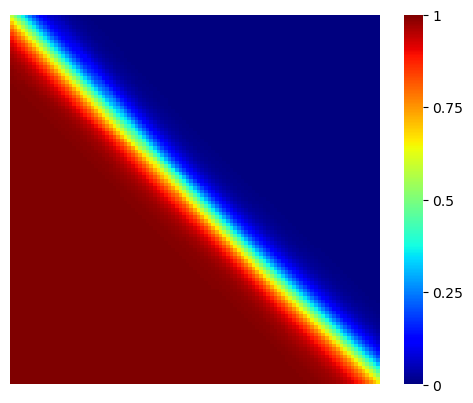

In [9]:
fig, ax = plt.subplots()
im = ax.imshow(np.flip(pred_probs.reshape(num_x, num_y), axis=0),cmap='jet')
cbar = fig.colorbar(im)
cbar.set_ticks([0,.25,.5,.75,1])
cbar.set_ticklabels([0,.25,.5,.75,1])
cbar.outline.set_linewidth(0)
ax.axis(False)
plt.show()

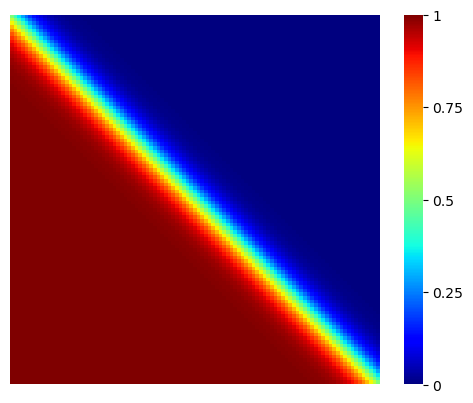

In [10]:
fig, ax = plt.subplots()
im = ax.imshow(np.flip(gt_probs.reshape(num_x, num_y), axis=0),cmap='jet')
cbar = fig.colorbar(im)
cbar.set_ticks([0,.25,.5,.75,1])
cbar.set_ticklabels([0,.25,.5,.75,1])
cbar.outline.set_linewidth(0)
ax.axis(False)
plt.show()

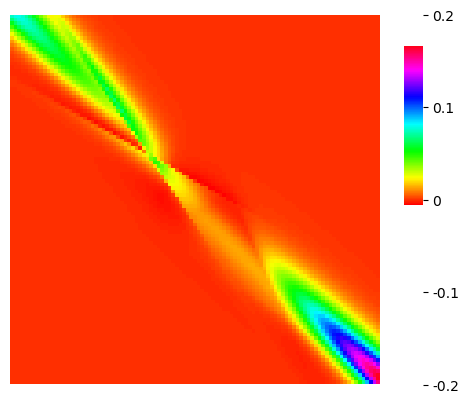

In [12]:
fig, ax = plt.subplots()
im = ax.imshow(np.flip((pred_probs-gt_probs).reshape(num_x, num_y), axis=0),cmap='hsv')
cbar = fig.colorbar(im)
cbar.set_ticks([-.2, -.1, 0,.1, .2])
cbar.set_ticklabels([-.2, -.1, 0,.1, .2])
cbar.outline.set_linewidth(0)
ax.axis(False)
plt.show()